In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
from statannotations.Annotator import Annotator #https://github.com/trevismd/statannotations

from itertools import combinations, cycle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# if getting OptionError: "No such keys(s): 'mode.use_inf_as_null'"
# !pip install --upgrade seaborn pandas

import matplotlib as mpl
import os
from glob import glob

from _load_data import * # Getting our specific labels, formatting, and data
from _cd_diagram import *

# Getting some free samples
results_df.sample(1)

print(gens)

# Don't change any code below, it may break (probably will) --------------------

['../models/SimplifierBottomUp.py', '../models/SimplifierBottomUpOnlyLast.py', '../models/SimplifierBottomUpMAB.py', '../models/SimplifierTopDown.py', '../models/Vanilla.py', '../models/SimplifierTopDownOnlyLast.py'] ['Bottom Up', 'Bottom Up (only last)', 'Bottom Up MAB', 'Top Down', 'Without simplify', 'Top Down (only last)']
(44, 14)
['Bottom Up' 'Bottom Up MAB' 'Without simplify']
['Airfoil' 'Concrete']
[10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 100]


In [2]:
results_df.groupby(['dataset']).model.value_counts()

dataset   model           
Airfoil   Bottom Up           10
          Bottom Up MAB       10
          Without simplify    10
Concrete  Without simplify    10
          Bottom Up            4
Name: model, dtype: int64

failed to add statsannotation with dataset Concrete. Except Missing x value(s) `"Bottom Up MAB"` in model (specified in `order`)


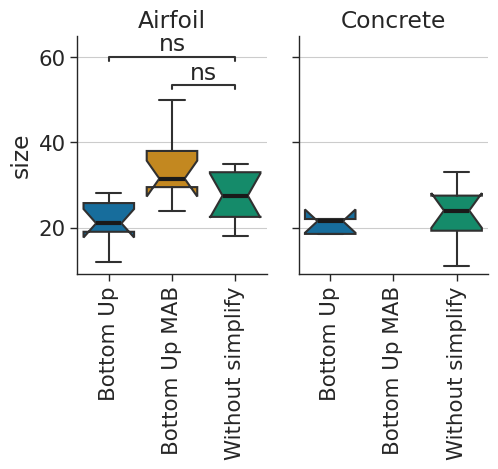

['Bottom Up' 'Bottom Up MAB' 'Without simplify']


final critical differences diagram
the null hypothesis over the entire classifiers cannot be rejected
failed to add statsannotation with dataset Concrete. Except Missing x value(s) `"Bottom Up MAB"` in model (specified in `order`)


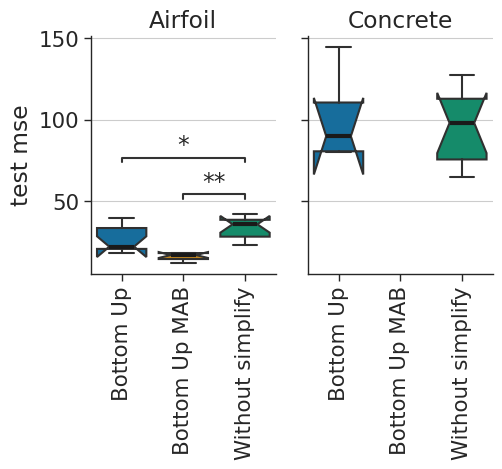

['Bottom Up' 'Bottom Up MAB' 'Without simplify']


final critical differences diagram


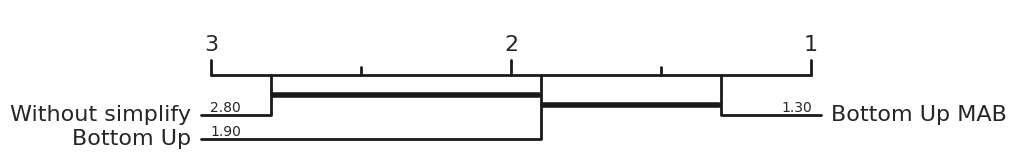

failed to add statsannotation with dataset Concrete. Except Missing x value(s) `"Bottom Up MAB"` in model (specified in `order`)


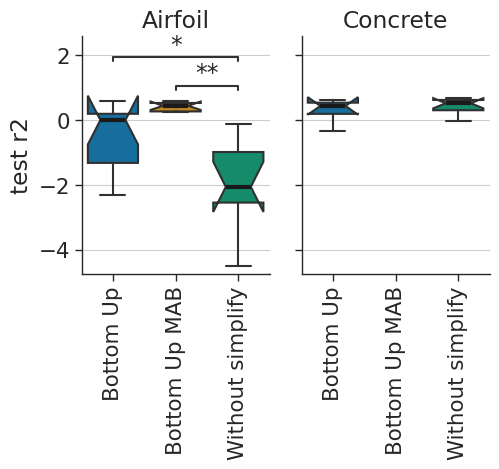

['Bottom Up' 'Bottom Up MAB' 'Without simplify']


final critical differences diagram


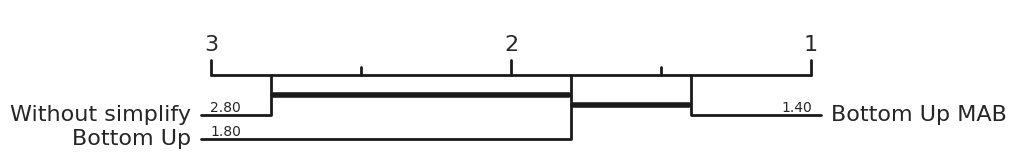

failed to add statsannotation with dataset Concrete. Except Missing x value(s) `"Bottom Up MAB"` in model (specified in `order`)


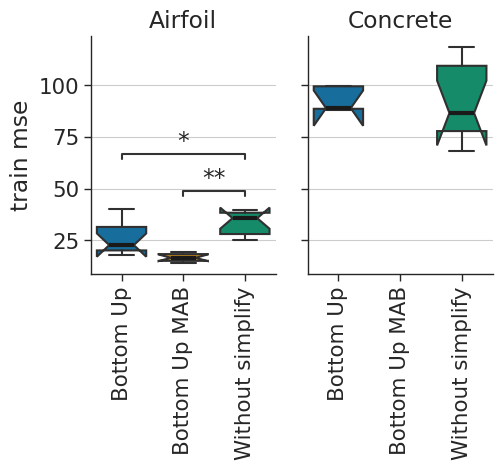

['Bottom Up' 'Bottom Up MAB' 'Without simplify']


final critical differences diagram


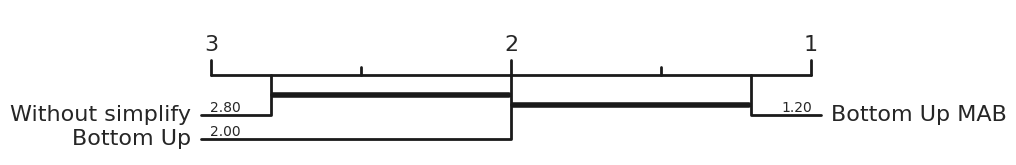

failed to add statsannotation with dataset Concrete. Except Missing x value(s) `"Bottom Up MAB"` in model (specified in `order`)


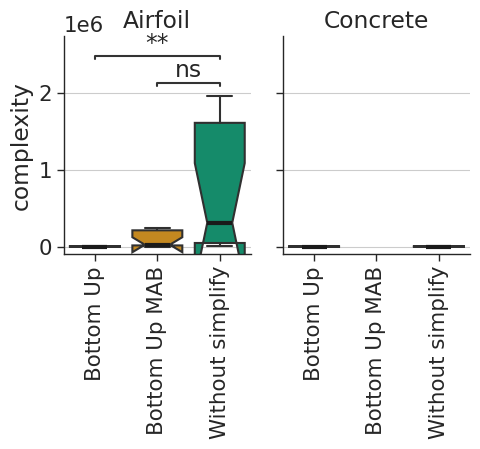

['Bottom Up' 'Bottom Up MAB' 'Without simplify']


final critical differences diagram


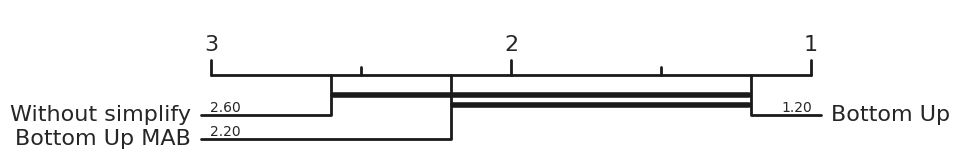

failed to add statsannotation with dataset Concrete. Except Missing x value(s) `"Bottom Up MAB"` in model (specified in `order`)


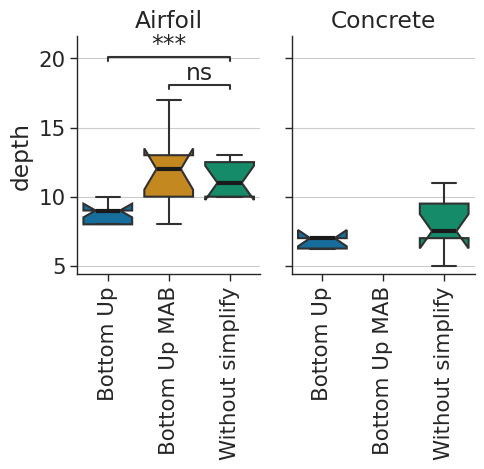

['Bottom Up' 'Bottom Up MAB' 'Without simplify']


final critical differences diagram


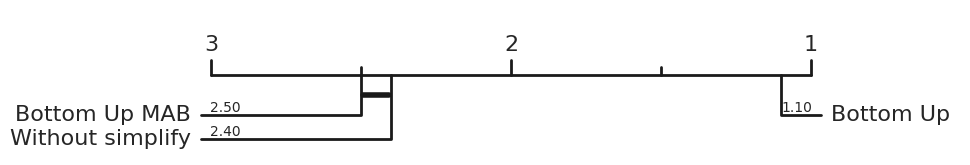

failed to add statsannotation with dataset Concrete. Except Missing x value(s) `"Bottom Up MAB"` in model (specified in `order`)


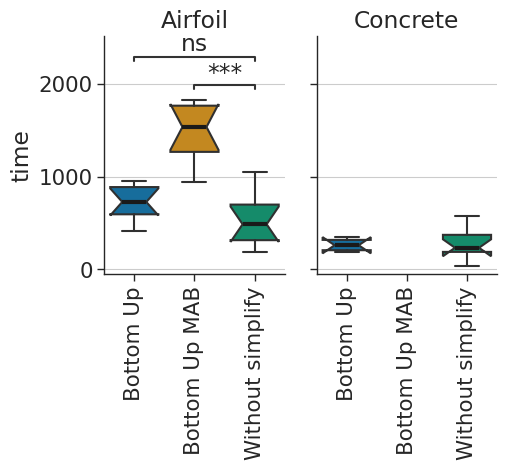

['Bottom Up' 'Bottom Up MAB' 'Without simplify']


final critical differences diagram


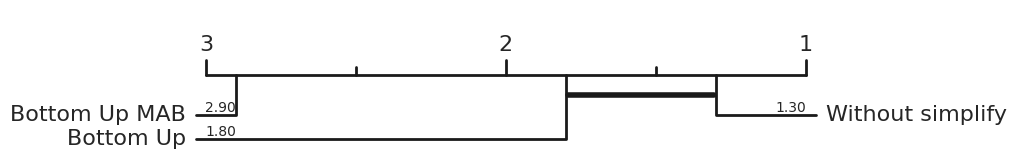

In [3]:
results_df['(only last)'] = results_df['model'].apply(lambda model: model.endswith("(only last)"))
  
for yaxis in ['size', 'test_mse', 'test_r2', 'train_mse', 'complexity', 'depth', 'time']:
    
    # Exploring boxplot results first
    g = sns.catplot(data=results_df, x='model', y=yaxis, hue='model',
        col='dataset', col_wrap=3, order=order, hue_order=order,
        **boxplot_kwargs, sharey=True, legend_out=False, aspect=0.5)

    # g.map_dataframe(sns.swarmplot, x="model", y=yaxis, 
    #                 palette=["#000000"], size=3,
    #                 alpha=0.5, dodge=True)

    g.set_titles("{col_name}").set_axis_labels("", yaxis.replace("_", " "))

    for (ds, plot_ax) in g._axes_dict.items():
        plot_ax.grid(which='major', axis='y', linewidth=.8)
        plot_ax.set_ylabel(plot_ax.get_ylabel().replace('_', ' '))

        
        for tick in plot_ax.get_xticklabels():
            tick.set(rotation=90, ha="center")
            

        # g.ax.set_xticklabels([tl.get_text().replace(' ', '\n')for tl in g.ax.get_xticklabels()], 
        #                     rotation=90, 
        #                     ha='center',  va='top', ma='right')
        
        # All vs baseline
        pairs = [('Without simplify', l)
                    for l in results_df[results_df['dataset']==ds]['model'].unique()
                    if l != 'Without simplify']

        # pairs = list(combinations(results_df[results_df['dataset']==ds]['model'].unique(), 2))

        if True:
            try:
                annotator = Annotator(
                    plot_ax, pairs, data=results_df[(results_df['dataset']==ds)],
                    x='model', y=yaxis,
                    order=order)
                annotator.reset_configuration()
                annotator.configure(test="Mann-Whitney", # text_format='simple', # hide_non_significant=True, #
                                    comparisons_correction="holm", verbose=0) # , text_offset=-3
                
                # Calculate and annotate
                annotator.apply_and_annotate()
            except Exception as e:
                print(f"failed to add statsannotation with dataset {ds}. Except {e}")

    # Adding hatches -------------------------------------------------------------------
    # comment/uncomment block to add hatches. Make sure to unco
    # comment hue when generating the plot
    #     hatches = ['///', 'xxx']
    #     # select the correct patches
    #     patches = [patch for patch in plot_ax.patches if type(patch) == mpl.patches.PathPatch]
    #     # the number of patches should be evenly divisible by the number of hatches
    #     h = hatches * (len(patches) // len(hatches))

    #     # iterate through the patches for each subplot
    #     for patch, model in zip(patches, order):
    #         if model != 'Without simplify':
    #             patch.set_hatch(hatches[0 if not model.endswith("simplify") else 1])
            
    # colorblind_palette = sns.color_palette('colorblind')
    
    # # Fixing the legend to add the hatches
    # for lp, hatch in zip(g.legend.get_patches(), hatches):
    #     lp.set_hatch(hatch)
        #lp.set_facecolor('blue')

    #g._legend.remove()
    # ----------------------------------------------------------------------------------
    #g.set(yscale="log")

    plt.tight_layout()
    plt.savefig(f"../paper/figs/{yaxis}_boxplot.pdf")
    plt.savefig(f"../paper/figs/{yaxis}_boxplot.png")
    plt.show()  
    
    if True:
        try:
            cd_df = results_df.copy()#.dropna() # (Just Island model sometimes gives an NAN)
            
            # Line below controls if we take the median or use each random seed as a different problem in CD
            # cd_df = cd_df.groupby(['model', 'dataset']).median().reset_index()
            
            cd_df = cd_df[cd_df.model.isin(model_nice)]
            print(cd_df.model.unique())
            cd_df['dataset_random_state'] = cd_df['dataset'] + '_' + cd_df['random_state'].astype(str)

            cd_df = cd_df[['model', 'dataset_random_state', yaxis]]

            # Ignoring random states with missing values
            frequency = cd_df['dataset_random_state'].value_counts()
            less_than = frequency[frequency < len(cd_df['model'].unique())]
            cd_df = cd_df[~cd_df['dataset_random_state'].isin(less_than.index)]
            
            display(cd_df.pivot('dataset_random_state', 'model').sample(3).style.background_gradient(cmap='viridis_r', axis=1))
            
            cd_df.columns = ['classifier_name', 'dataset_name', 'accuracy']
            # display(cd_df.sample())

            if yaxis != 'test_r2': # if smaller is better
                cd_df.accuracy = cd_df.accuracy*-1 

            # for ds in results_df['dataset'].unique():
            #     print(ds)
            #     draw_cd_diagram(cd_df[cd_df['dataset_name'].str.startswith(ds)],
            #                    alpha=0.05, path=f"../paper/figs/{yaxis}_criticaldifferences_{ds}.pdf")

            print("final critical differences diagram")
            draw_cd_diagram(cd_df, alpha=0.05, path=f"../paper/figs/{yaxis}_criticaldifferences.pdf")
        except Exception as e:
            print(f'Failed to generate the CD. error {e}')